__Written by : RAJENDRA THAPA on August 07, 2020.__

__This code calculates the DOS and IPR from DOSCAR and POSCAR. The only input needed from the user is the number of atomic species and the number of atoms of each type. This code is written for systems with three atomic species. Modify the code if otherwise.__

Enter the number of species: 3
The ordering of the atoms must be the same as in POSCAR.
No. of atoms of each species:138
No. of atoms of each species:24
No. of atoms of each species:138


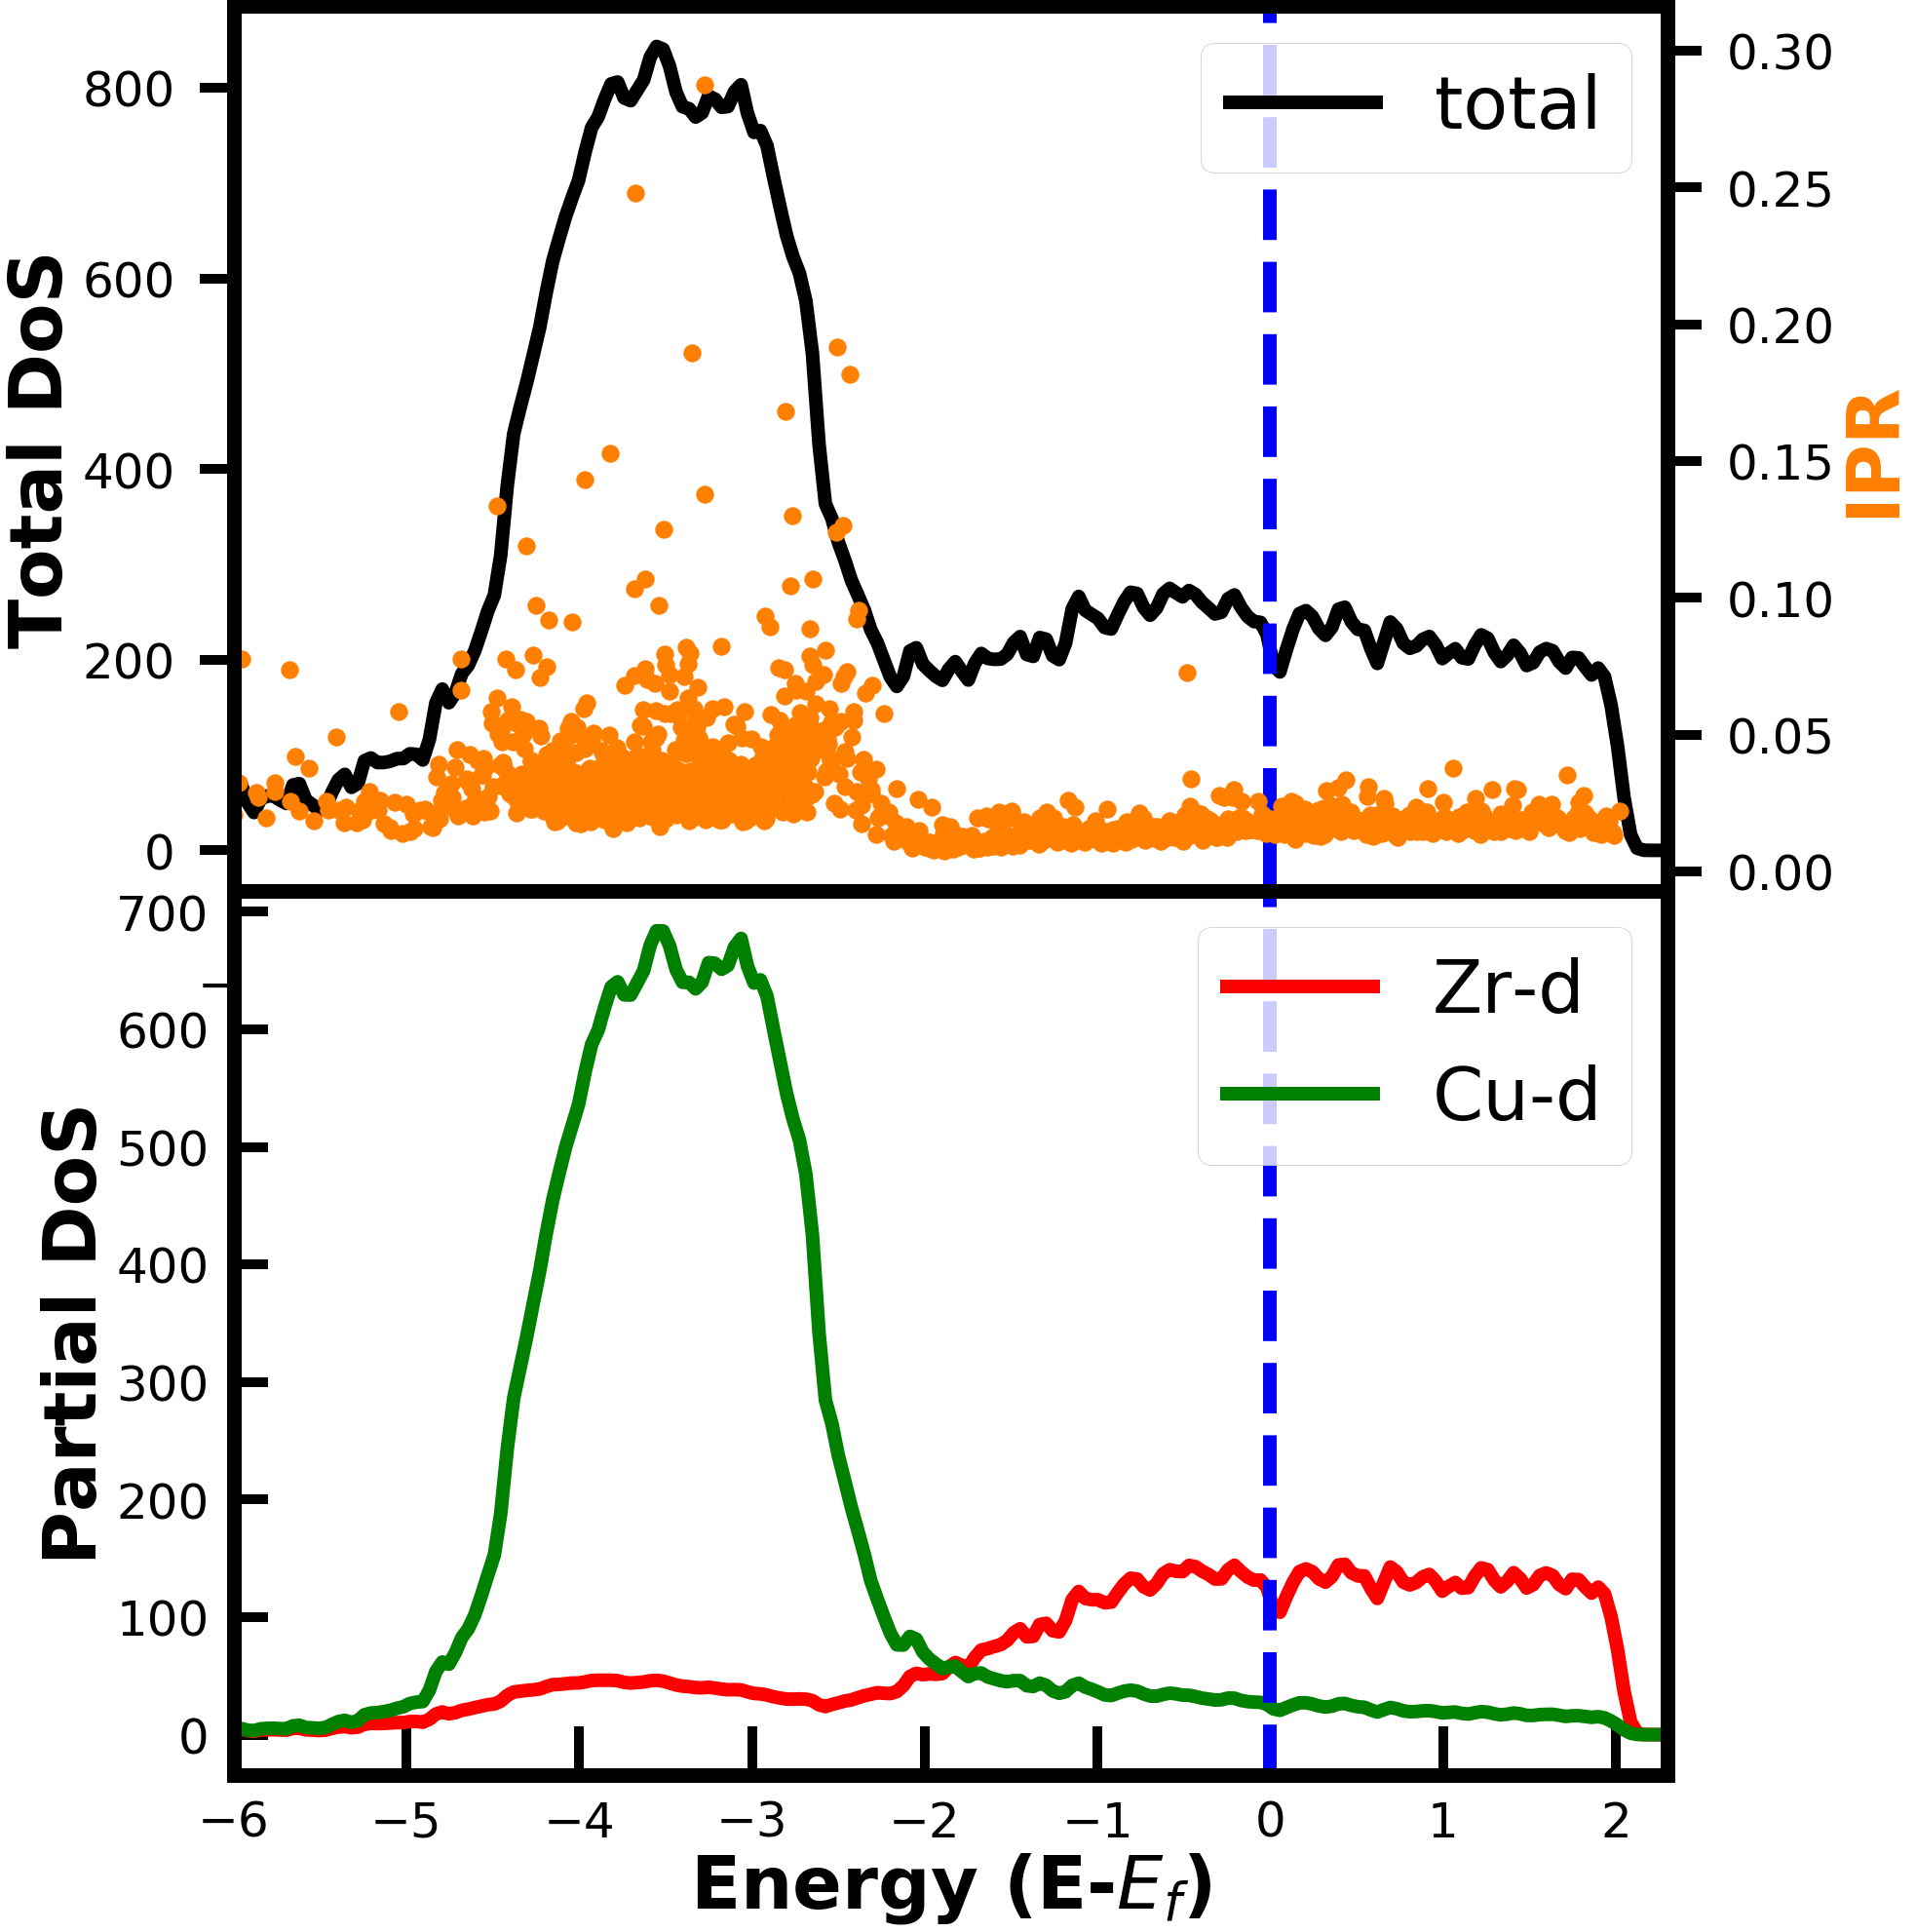

In [11]:
import numpy as np
import matplotlib.pyplot as plt
##################################################
########Function Definition#######################
##################################################
def get_total_DoS(filename):
    ''' Reads the DoS from the DOSCAR. 
    Args:
        filename : vasp DOSCAR
    Returns:
        DoS, Ef : 301 lines of DoS and Fermi energy
    '''
    f = open(filename,"r")     #open the file
    lines = f.readlines()      #read each line
    f.close()                  #close the file
    copy = False               #set a Boolean to flag when to copy 
    dos = []                   #set an array for storing quantities you need
    for line in lines[:307]:   #repeat it for all line in lines
        inp = line.split()     #split each line 
        if len(inp) == 5 and inp[2] == '301': 
            EF = float(inp[3] )
            copy = True
            continue                            
        if copy:                                
            if len(inp) == 3 and float(inp[1]) >= 0.0: 
                dos.append(inp[:2])                                    
    return np.asarray(dos).astype(np.float), EF
##################################################################### 
def get_DoS_Partial(filename):
    count = 307
    fi = open(filename,"r")
    LINES = fi.readlines()
    fi.close()
    copy = False
    partial_I,partial_II,partial_III = [],[],[]
    first  = 307+N_type[0]*302 
    second = first+302*N_type[1] 
    third  = second+302*N_type[2] 
    while count < first:
        inp = LINES[count].split()
        count += 1
        if len(inp) == 5 and inp[2] == '301':
            copy = True
            continue
        if copy:
            if len(inp) == 4 and float(inp[1]) >= 0.0:
                partial_I.append(inp[1:])
    while count < second:
        inp = LINES[count].split()
        count += 1
        if len(inp) == 5 and inp[2] == '301':
            copy = True
            continue
        if copy:
            if len(inp) == 4 and float(inp[1]) >= 0.0:
                partial_II.append(inp[1:])
    while count < third:
        inp = LINES[count].split()
        count += 1
        if len(inp) == 5 and inp[2] == '301':
            copy = True
            continue
        if copy:
            if len(inp) == 4 and float(inp[1]) >= 0.0:
                partial_III.append(inp[1:])
    return np.asarray(partial_I).astype(np.float),np.asarray(partial_II).astype(np.float),np.asarray(partial_III).astype(np.float)
#####################################################################
def get_IPR(filename):
    F = open(filename,"r")     #open the file
    lines = F.readlines()      #read each line
    F.close()                  #close the file
    copy = False               #set a Boolean to flag when to copy 
    wvf  = []                   #set an array for storing quantities you need
    en   = []
    for line in lines:   #repeat it for all line in lines
        inp = line.split()     #split each line 
        if len(inp) == 8 and inp[0] == 'band': 
            en.append(inp[4])
        if len(inp) == 5 and inp[0] == 'ion' :            
            copy = True
            continue  
        if len(inp) == 5 and inp[0] == 'tot':
            copy = False
            continue
        if copy:                                
            if len(inp) == 5 and float(inp[1]) >= 0.0: 
                wvf.append(inp[4])  
    return np.asarray(wvf).astype(np.float),np.asarray(en).astype(np.float)
#####################################################################
################### Get the total DoS ###############################
#####################################################################
DoS, Ef = get_total_DoS('DOSCAR')
DoS[:,0] -= Ef                         #Subtract Fermi energy from each energy value
#####################################################################
################### Get the Partial DoS #############################
#####################################################################
N_type = []                                         #Create a list to hold number of atom of each species
ntypes = int(input("Enter the number of species: "))
print("The ordering of the atoms must be the same as in POSCAR.")
for ind in range(0,ntypes):
    ele = int(input("No. of atoms of each species:"))
    N_type.append(ele)
NATOMS = np.sum(np.asarray(N_type))
part_I,part_II,part_III = get_DoS_Partial("DOSCAR")   #Wavefunction for each band for each atom
DoS_I = np.zeros([301,3])                             #Store The partial DoS from s,p,d orbitals for each atom type
DoS_II = np.zeros([301,3])
DoS_III = np.zeros([301,3])
rows =0                          #Initialize to the first row for each atom type
while rows < 301:
    DoS_I[rows,:]   = part_I[rows,:]
    DoS_II[rows,:]  = part_II[rows,:]
    DoS_III[rows,:] = part_III[rows,:]
    rows += 1
rowsI,rowsII,rowsIII = 301,301,301
while rowsI < len(part_I):
    rem = rowsI%301
    DoS_I [rem,:] += part_I[rowsI,:]
    rowsI += 1
while rowsII < len(part_II):
    rem = rowsII%301
    DoS_II [rem,:] += part_II[rowsII,:]
    rowsII += 1
while rowsIII < len(part_III):
    rem = rowsIII%301
    DoS_III [rem,:] += part_III[rowsIII,:]
    rowsIII += 1
#####################################################################
################### Get the IPR  ####################################
#####################################################################
wvf,EN = get_IPR("PROCAR")
NB = len(EN)                 #No of bands in PROCAR. This is not the same as DOSCAR
band = 0
tmp = np.zeros([NB,NATOMS],float)
IPR = np.zeros([NB],float)
while band < NB:
    N_ = band*NATOMS
    atoms, num, den = 0, 0, 0
    while atoms < NATOMS:
        tmp[band][atoms] = wvf[N_ + atoms]
        num += (tmp[band][atoms])**4
        den += (tmp[band][atoms])**2
        atoms += 1
    IPR[band] = num/den**2
    band += 1
##############################################################################
######################################### Plot the results ###################
##############################################################################
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['font.size'] = 75
plt.rcParams['axes.labelsize'] = 75
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.titlesize'] = 75
plt.rcParams['axes.titleweight']='normal'
plt.rcParams['xtick.labelsize'] =50
plt.rcParams['ytick.labelsize'] =50
plt.rcParams['lines.linewidth']=14.0
plt.rcParams['figure.figsize'] = 28,30
plt.rcParams['lines.markersize']=15
plt.rcParams['axes.linewidth'] =15

plt.rcParams['xtick.major.size']=50
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['xtick.major.width']=10.0

plt.rcParams['ytick.major.size']=35
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['ytick.major.width']=10.0

plt.rcParams['xtick.major.pad']='25'
plt.rcParams['ytick.major.pad']='25'

left,bottom,width,height = 0.15,0.10,0.73,0.42
rect_two     = [left,bottom,width,height]
rect_three   = [left,bottom+height,width,height]
three_plot   = plt.axes(rect_three)
two_plot     = plt.axes(rect_two)
########################################################################
three_plot.plot(DoS[:,0],DoS[:,1],color='k',label='total')      
three_plot.set_ylabel("Total DoS",fontweight='bold')
three_plot.tick_params(direction='out')
three_plot.legend(loc='upper right')
three_plot.set_xlim(-6,2.3)
three_plot.axvline(x=0,ls= '--',color='b')
plt_32 = three_plot.twinx()                       #CREATE A SECOND set AXES THAT SHARES X-AXIS WITH three_plot
plt_32.scatter(EN-Ef,IPR,s=300.0,color='#ff7f00')
plt_32.set_ylabel("IPR", color='#ff7f00',fontweight='bold')
plt_32.set_ylim(np.amin(IPR)-0.05*np.amax(IPR),np.amax(IPR)*1.1)
plt_32.tick_params(direction='out')
two_plot.plot(DoS[:,0],DoS_I[:,2],color='r',label='Zr-d')  
two_plot.plot(DoS[:,0],DoS_III[:,2],color='g',label='Cu-d') 
two_plot.legend()
two_plot.set_ylabel("Partial DoS",fontweight='bold')
two_plot.set_xlabel("Energy (E-$E_f$)",fontweight='bold')
two_plot.set_xlim(-6,2.3)
two_plot.axvline(x=0,ls= '--',color='b')

plt.savefig("DoS_IPR.pdf",dpi=1500)
plt.show()
